<a href="https://colab.research.google.com/github/aholanda/rrwg/blob/main/rrwg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforced Random Walks on Graphs

We implement the vertex-Reinforced Random Walks on Graphs (RRWG) simulation as defined in [[Rosales, 2022](https://doi.org/10.1016/j.spa.2022.03.007)].

## Graphs
We consider a complete, unweighted, undirected graph $G=\{V, E\}$ with self-loops and $|V|>1$. We assume that $V$ is a finite set with $n$ vertices.

In [331]:
import networkx as nx

def create_graph(number_of_vertices, has_loops=True) -> nx.Graph:
    """Return a Networkx complete graph with `number_of_vertices` 
    as specified.

    Self-loop are added automatically if `has_loops` 
    variable is set true and not added otherwise.         
    """
    G = nx.complete_graph(number_of_vertices)

    for v in range(G.order()):
        if has_loops:
            G.add_edge(v,v)
        else:
            if (v,v) in G.edges():
                G.remove_edge(v,v)
    return G

## Walks
Let $W$ be a set of walks on G where at each step, a walk can select a vertex adjacent to the current vertex or keep its location.

In [332]:
class Walks():
    def __init__(self, number_of_walks):
        self._m = number_of_walks
 
    def __len__(self):
        """Return the number of walks.
        """
        return self._m

## The simulation

The `RRWG` class is a placeholder for the procedures to perform the RRWG simulation. The `walk()` method traverse the walks at each time step $t$ to change their current location or to keep them at the same place using the transition probability defined in [[Rosales, 2022](https://doi.org/10.1016/j.spa.2022.03.007)].

In [333]:

import math
import numpy as np
import random
import sys

NOVAL = -1

class RRWG():
    def __init__(self, W: Walks, G: Graph):
        """Initialize the class with a set of walks, a graph and the 
        parameters needed to perform the W steps on G.
        """
        self._W = W
        self._m = len(self._W) # number of walks
        self._G = G
        self._n = self._G.order() # number of vertices

    def init_buffer(self, W_start_at: list, nvisits0):
        """Initialize the structures used to save the results.
        """
        # Current location for each walk in terms of vertices
        self._curr_locs = np.full(self._m, NOVAL, dtype=int)
        # If initial location for the walks is not set,
        # the walks are set with the vertices with the same
        # index after applying the modulo operation.
        if W_start_at == None:
            for w in range(self._m):
                self._curr_locs[w] = w % self._n
        else:
            self._curr_locs = np.array(W_start_at)
        # Count the number of walks' visits at each vertex.
        # Each matrix column is mapped to a vertex v and the number
        # of columns is |V|. The matrix line index represents the walk w.
        # Representation: matrix[w, v] <- nvisits [default=1]
        # As an example if the |W| = 2 and |V| = 3, the matrix is
        # [[w0v0 w0v1 w0v2],
        #  [w1v0 w1v1 w1v2]]
        # [[ 1    1    1 ],
        #  [ 1    1    1 ]] for t=0 (if not modified)
        if nvisits0 != None:
            self._nvisits0 = np.copy(np.array(nvisits0)) # TODO: test
            self._nvisits = np.copy(np.array(nvisits0)) # TODO: test
        else:
            self._nvisits = np.full((self._m, self._n), 
                                 1, dtype=int)
            # Save the number of visits at t=0
            self._nvisits0 = np.full((self._m, self._n), 
                                 1, dtype=int)

        # The walks locations in terms of vertices per time 
        # is saved in a matrix [T, |W|]
        self._locations = np.full((self._tmax, self._m), NOVAL, dtype=int)
        self._locations[0] = self._curr_locs # initialize for t=0

    # Utils methods
    def V(self):
        """Return the vertices index as an array.
        """
        return np.arange(self._G.order())

    def W(self):
        """Return the walks index as an array.
        """
        return np.arange(self._m)
    
    def col(self, w: int, v: int) -> int:
        """Return the column index in the matrix for the tuple (w,v).
        """
        return w*self._n + v

    def nsteps(self) -> int:
        """Return the number of steps, including steps at t=0.
        """
        return self._tmax
    # END of Utils methods
    
    def get_curr_location(self, walk: int):
        """Return the current location for the walk.
        """
        return self._curr_locs[walk]

    def visit(self, t: int, w: int, v: int):
        self._curr_locs[w] = v
        # Increment the number of visits for walk w 
        # in the vertex v.
        self._nvisits[w, v] += 1
        # Set the w location at time t
        self._locations[t, w] = v

    def get_nvisits(self, w: int, v: int) -> int:
        return self._nvisits[w, v]

    def get_normalized_nvisits(self):
        self._nvis_norm = \
            np.full((self._tmax, self._m*self._n), 0.0, dtype=float)

        # Initialize with the number of visits at t=0.
        for w in self.W():
            for v in self.V():
                col = self.col(w, v)
                self._nvis_norm[0, col] = self._nvisits0[w, v]

        # Count of number of visits using the locations
        # along the walk.
        for t in range(1, self._tmax):
            for w in range(len(self._W)):
                for v in self.V():
                    col = self.col(w, v)
                    # repeat the values before the current time
                    self._nvis_norm[t, col] = \
                            self._nvis_norm[t-1, col]
                    # increment the visits occurred at time t
                    if v == self._locations[t, w]:
                        self._nvis_norm[t, col] += 1
        # Nomalize
        for t in range(self._tmax):        
            for w in range(len(self._W)):
                for v in self.V():
                    col = self.col(w, v)
                    l = w*self._n
                    r = l + self._n
                    self._nvis_norm[t, l:r] /= \
                        np.sum(self._nvis_norm[t, l:r])

        return self._nvis_norm

    def start_at(self, vs_at_t0_arr: list):
        """Initialize the walks' current location and 
        the number of visits at t=0.
    
        vs_at_t0_arr (list): array with vertices indices where
                             each array index is an walk index.
        """
        for w, v in enumerate(vs_at_t0_arr):
            self.visit(w, v)
      
    def X(self, w, v):
        nvis = self._nvisits[w, v]
        # sum all visits at the vertex v
        vsum = np.sum(self._nvisits[:, v])
        return float(nvis)/vsum

    def X_sum(self, w_curr, v):
        X_sum = 0.0

        # Traverse the other walks
        for w in range(self._m):
            if w == w_curr: # ignore current walk
                continue
            X_sum += self.X(w, v)
        return X_sum

    def __exp(self, w_curr, v):
        x = self.X_sum(w_curr, v)
        #print('\t\t__exp: t={}, w{}, v{}={}'.format(t, w_curr, v, x))
        return math.exp(-self._alpha*x)

    def __pow(self, w_curr, v):
        factor = self.X(w_curr, v)
    
        return factor * pow(self._m - self.X_sum(w_curr, v), self._alpha)

    def set_function(self, label):
        # Function to calculated reinforcement value.
        if label == 'EXP':
            self.function = self.__exp
        elif label == 'POW':
            self.function = self.__pow
        else:
            sys.exit('unknown function {}'.format(label))

    def Pr(self, w_curr, v_src, v_dest):
        # The values from the time step before the current
        # are used to calculate the probability.
        pr_v = 0.0
        pr_sum = 0.0

        for v in self._G.neighbors(v_src):
            pr = self.function(w_curr, v)
            pr_sum += pr

            if v == v_dest:
                pr_v = pr

        return pr_v/pr_sum

    def print_banner(self):
        startstr = 'RRWG(v{}): '.format(__version__)
        startstr += '|W|={}, |V|={}, alpha={}\n'\
                    .format(self._m, self._n, self._alpha)
        for w in self.W():
            startstr += '  w{} started at v{}\n' \
                        .format(w, self._curr_locs[w])
        startstr += '  visits at t=0: {}\n'.format(self._nvisits[0])
        print(startstr)

    def walk(self, number_of_steps: int, alpha: float, 
             funcname='EXP', W_start_at=None, nvisits0=None):
        # Number of steps plus one to count t=0
        # that is the time exactly before the walks
        # start.
        self._tmax = number_of_steps+1
        self._alpha = alpha
        self.set_function(funcname)
        self.init_buffer(W_start_at, nvisits0)
        self.print_banner()

        for t in range(1, self._tmax):
            # Save the next vertex destination for the walks
            # to update the number of visits at once.
            locs_t = np.full(self._m, NOVAL, dtype=int)
            # Traverse current walks' locations.
            for w in range(self._m):
                # Initialize the array of probability transitions
                # of w goto v with zeros.
                probs = np.zeros(self._n)
  
                # We use sorted() to always have a ordered
                # list of neighbors.
                # Traverse the neighbors of vertex u to
                # calculate the transition probability 
                # of w go to the one of u neighbors.
                u = self.get_curr_location(w)
                neighbs = list(self._G.neighbors(u))
                for v in neighbs:
                    probs[v] = self.Pr(w, u, v)
                    # TODO: add verbose?
                    #print('{}: Pr(w{}, v{} -> v{})={}'\
                    #      .format(t, w, u, v, probs[v]))

                # Sum the transition probabilies
                probs_sum = np.sum(probs)
                # Generate a random number between 0.0 and probs_sum
                rand = np.random.uniform(0.0, probs_sum)
                # Choose the next vertex destination
                probs_sum = 0.0
                for v in neighbs:
                    probs_sum += probs[v]
                    if probs_sum > rand:
                        locs_t[w] = v
                        #print('\tR={:.3f}, w{} goto v{}'
                        #      .format(rand, w, v))
                        break
            # Update visits
            for w in self.W():
                v = locs_t[w]
                self.visit(t, w, v)

## Plotting

A plot procedure is implemented intended to show for each walk the number of visits per vertex as a function of time.

In [334]:

import matplotlib.pyplot as plt

def plot(rrwg, title):
    # Get the matrix with normalized number of visits
    # where the lines are t and the columns are w*n+v,
    # where n is the number of vertices.
    nvis = rrwg.get_normalized_nvisits()
    # number of vertices
    n = rrwg._G.order()
    # number of walks
    m = len(rrwg._W)
    # time steps
    xs = np.arange(rrwg.nsteps())
    labels = ['$v_{}$'.format(v) for v in range(n)]

    fig, axs = plt.subplots(m, sharex=True)
    fig.suptitle(title)

    for w in range(m):
        axs[w].set_ylim([0.0, 1.0])
        axs[w].set_ylabel('visits($w_{}$)'.format(w))
        for v in range(n):
            col = w*n + v
            ys = nvis[:, col]
            axs[w].plot(xs, ys, label='$v_{}$'.format(v))
        axs[w].legend()
    plt.xlabel('t')
    plt.show()

## Initialization and walking

RRWG(v1.1): |W|=2, |V|=2, alpha=4.1
  w0 started at v0
  w1 started at v1
  visits at t=0: [1 1]



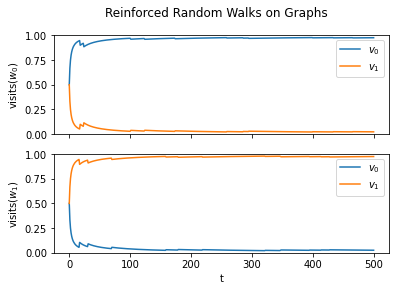

In [335]:
__version__ = '1.1'
def main():
    TITLE = 'Reinforced Random Walks on Graphs'
    #
    # GRAPH
    #
    N = 2 #<======== Number of vertices
    LOOPS = True  # Self-loops are allowed?
    # Graph initialization
    G = create_graph(N, LOOPS)

    #
    # Walks
    #
    M = 2 #<======== Number of Walks
    # Walks initialization
    W = Walks(M)

    #
    # RRWG
    #
    T = 500 #<======== Maximum number of steps
    ALPHA = 4.1 #<======== Reinforcement factor
    # Set the number of walks' visits before the
    # walks start. The visits are represented as 
    # a matrix where the line number is the walk 
    # index and the column number is the vertex index.
    #<========
    # NVISITS0 = np.array([[1, 2],
    #                     [3, 4]])
    # When NVISITS is not initialized, all visits
    # are set with value 1.
    NVISITS0 = None
    # Array with the vertices where each walk starts
    # before the simulation begins. For example,
    #<========
    # W_START_AT = [1, 0]
    # means that walk 0 starts at vertex 1 and walk 1
    # starts at vertex 0.
    # If W_START_AT is not initialized, the initial location
    # is randomly chosen.
    rrwg = RRWG(W, G)

    # Full arguments passing
    #rrwg.walk(T, ALPHA, 'EXP', W_START_AT, NVISITS0)
    f = 'EXP' # Possible values: 'EXP' , 'POW' 
    rrwg.walk(T, ALPHA, f)

    plot(rrwg, TITLE)
#    print(rrwg._locations)
#    print(rrwg._nvis_norm)

main()